In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 10000)

import pandas_profiling
from wordcloud import WordCloud

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

import requests
import json

import geopandas as gpd

%matplotlib inline
import missingno as msno

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [2]:
df_store_history = pd.read_pickle('df_점포이력_상권_좌표.pki')
df_store_history

,adres,svcIndutyCdNm,storNm,opbizYm,clsbizYm,totalCount,coordx,coordy,상권코드,x,y
0,서울특별시 강서구 과해동 272번지,화초,BFA,200301,,126,181274,451391,미정,126.787994,37.561754
1,서울특별시 강서구 과해동 272번지,주유소,SK네트웍스이마트김포,200301,,126,181274,451391,미정,126.787994,37.561754
2,서울특별시 강서구 과해동 272번지,양식음식점,가쯔레쯔왕,200301,,126,181274,451391,미정,126.787994,37.561754
3,서울특별시 강서구 과해동 272번지,일반의류,공항이마트에이니,201209,,126,181274,451391,미정,126.787994,37.561754
4,서울특별시 강서구 과해동 272번지 기린약국,의약품,기린약국,200407,,126,181274,451391,미정,126.787994,37.561754
...,...,...,...,...,...,...,...,...,...,...,...
1941806,"서울특별시 강동구 아리수로97길 20, 504동 1402호 (강일동,강일리버파크5단...",일반의류,피엔디,201208,201304,4,215785,452021,미정,127.178624,37.567488
1941807,"서울특별시 강동구 고덕로97길 20, 1011동 605호 (강일동,강일리버파크10단...",육류판매,광양식불고기,201109,201112,1,215921,451192,미정,127.180146,37.560016
1941808,서울특별시 강동구 초광로294번길 154 (상일동),자동차수리,사토개러지,201609,,3,216103,449796,미정,127.182175,37.547435
1941809,서울특별시 강동구 초광로294번길 154 (상일동),자동차수리,사토개러지,201507,201609,3,216103,449796,미정,127.182175,37.547435


### 전처리 전략

1. adres : df_상가현황 주조에 merge 한다.
 * 전체주소는 좌표생성 위해서 남겨둔다.
 
2. opbizYm, clsbizYm : dtype => data type 바꾸고 영업기간_년 콜론을 새로 만든다

3. storNm : 업종소분류로 쪼개본다.
 * 소분류리스트 가져와서, for 문 돌려서 일치항목 리스트에 넣기




#### 1. adres : 시군구_코드_명, 행정동_코드_명 콜론 추가로 만들기

In [3]:
df_store_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941811 entries, 0 to 1941810
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   adres          object 
 1   svcIndutyCdNm  object 
 2   storNm         object 
 3   opbizYm        int64  
 4   clsbizYm       object 
 5   totalCount     int64  
 6   coordx         int64  
 7   coordy         int64  
 8   상권코드           object 
 9   x              float64
 10  y              float64
dtypes: float64(2), int64(4), object(5)
memory usage: 177.8+ MB


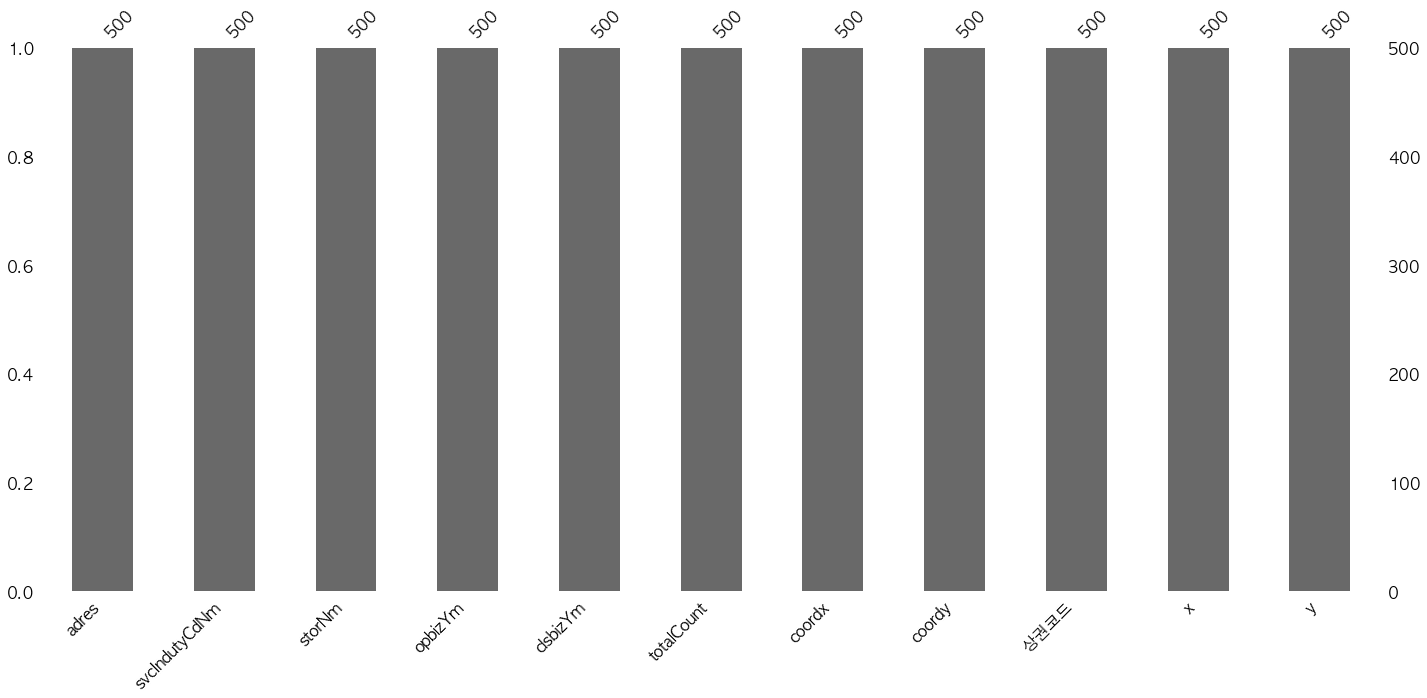

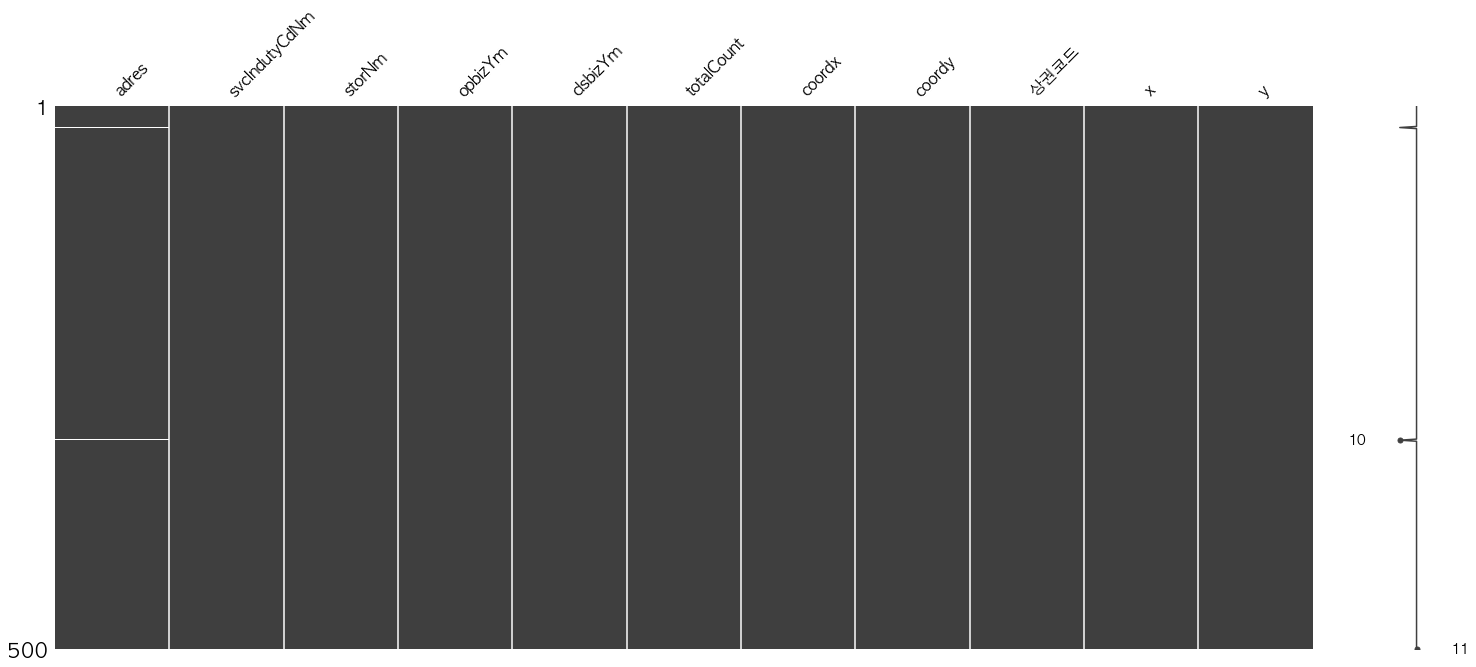

In [4]:
# null 값 확인
msno.bar(df_store_history.sample(500))
msno.matrix(df_store_history.sample(500))

In [5]:
# 주소 없는 data 6316 개
sum(df_store_history['adres'].isnull())

6316

In [6]:
# adres 콜론 null 값 채우기
df_store_history['adres'].fillna('서울특별시 행정구 행정동 기타주소', inplace=True)

In [7]:
temp = df_store_history['adres']
temp

0                                        서울특별시 강서구 과해동 272번지
1                                        서울특별시 강서구 과해동 272번지
2                                        서울특별시 강서구 과해동 272번지
3                                        서울특별시 강서구 과해동 272번지
4                                   서울특별시 강서구 과해동 272번지 기린약국
                                 ...                        
1941806    서울특별시 강동구 아리수로97길 20, 504동 1402호 (강일동,강일리버파크5단...
1941807    서울특별시 강동구 고덕로97길 20, 1011동 605호 (강일동,강일리버파크10단...
1941808                         서울특별시 강동구 초광로294번길 154 (상일동)
1941809                         서울특별시 강동구 초광로294번길 154 (상일동)
1941810               서울특별시 강동구 초광로294번길 154, 1,2층 (상일동,본건물)
Name: adres, Length: 1941811, dtype: object

In [8]:
df_store_history.columns

Index(['adres', 'svcIndutyCdNm', 'storNm', 'opbizYm', 'clsbizYm', 'totalCount',
       'coordx', 'coordy', '상권코드', 'x', 'y'],
      dtype='object')

In [9]:
# 도로명주소 걸러내기
df_temp = df_store_history['adres'].apply(lambda x : x.split(' ')[2])
# df_temp = df_temp.apply(lambda x : " ".join(x))
df_store_history['도로명'] = df_temp
df_store_history = df_store_history[['adres','도로명','svcIndutyCdNm','storNm','상권코드','totalCount','coordx', 'coordy','x', 'y',
                                     'opbizYm', 'clsbizYm']]
df_store_history.head(1)

,adres,도로명,svcIndutyCdNm,storNm,상권코드,totalCount,coordx,coordy,x,y,opbizYm,clsbizYm
0,서울특별시 강서구 과해동 272번지,과해동,화초,BFA,미정,126,181274,451391,126.787994,37.561754,200301,


In [10]:
# 주소가 없는 data 가 6316 개 있다. 대신 좌표는 있음
df_store_history[df_store_history['도로명']=='행정동']

,adres,도로명,svcIndutyCdNm,storNm,상권코드,totalCount,coordx,coordy,x,y,opbizYm,clsbizYm
334,서울특별시 행정구 행정동 기타주소,행정동,모터사이클수리,팔팔오토바이,양천로24가길,1,183380,452400,126.811807,37.570886,201506,201809
598,서울특별시 행정구 행정동 기타주소,행정동,일반의류,간지,양천로24길,5,183722,452134,126.815685,37.568495,201103,201203
2979,서울특별시 행정구 행정동 기타주소,행정동,일반의류,드레스코드,신정3동골목시장,8,186958,446626,126.852413,37.518920,200605,201812
3548,서울특별시 행정구 행정동 기타주소,행정동,전자상거래업,제이플로라,은행정로5길,1,187447,446844,126.857941,37.520891,201001,201201
3578,서울특별시 행정구 행정동 기타주소,행정동,미곡판매,대흥상회,은행정로5길,1,187479,446816,126.858304,37.520639,198601,200603
...,...,...,...,...,...,...,...,...,...,...,...,...
1939087,서울특별시 행정구 행정동 기타주소,행정동,커피-음료,아썸,고덕로10길,2,211288,450428,127.127696,37.553201,201209,201812
1940541,서울특별시 행정구 행정동 기타주소,행정동,일반의류,에벤에셀,암사길,1,212140,450308,127.137337,37.552109,201609,
1940801,서울특별시 행정구 행정동 기타주소,행정동,화장품,생명샘,천중로39길,2,212422,449480,127.140514,37.544645,201301,201405
1941348,서울특별시 행정구 행정동 기타주소,행정동,한식음식점,대천식당,천호대로197길,1,212933,448615,127.146281,37.536844,200511,201512


#### 2. opbizYm, clsbizYm : dtype => data type 바꾸고 영업기간_년 콜론을 새로 만든다

In [11]:
# 영업중인 업체 null 값 202012로 채워주기
df_store_history['영업일계산기준일'] = df_store_history['clsbizYm']
df_store_history['영업일계산기준일'].fillna('202012', inplace=True)
df_store_history

<ipython-input-11-0638535468a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_history['영업일계산기준일'] = df_store_history['clsbizYm']
/Users/SSO/opt/anaconda3/envs/crawling/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,adres,도로명,svcIndutyCdNm,storNm,상권코드,totalCount,coordx,coordy,x,y,opbizYm,clsbizYm,영업일계산기준일
0,서울특별시 강서구 과해동 272번지,과해동,화초,BFA,미정,126,181274,451391,126.787994,37.561754,200301,,
1,서울특별시 강서구 과해동 272번지,과해동,주유소,SK네트웍스이마트김포,미정,126,181274,451391,126.787994,37.561754,200301,,
2,서울특별시 강서구 과해동 272번지,과해동,양식음식점,가쯔레쯔왕,미정,126,181274,451391,126.787994,37.561754,200301,,
3,서울특별시 강서구 과해동 272번지,과해동,일반의류,공항이마트에이니,미정,126,181274,451391,126.787994,37.561754,201209,,
4,서울특별시 강서구 과해동 272번지 기린약국,과해동,의약품,기린약국,미정,126,181274,451391,126.787994,37.561754,200407,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941806,"서울특별시 강동구 아리수로97길 20, 504동 1402호 (강일동,강일리버파크5단...",아리수로97길,일반의류,피엔디,미정,4,215785,452021,127.178624,37.567488,201208,201304,201304
1941807,"서울특별시 강동구 고덕로97길 20, 1011동 605호 (강일동,강일리버파크10단...",고덕로97길,육류판매,광양식불고기,미정,1,215921,451192,127.180146,37.560016,201109,201112,201112
1941808,서울특별시 강동구 초광로294번길 154 (상일동),초광로294번길,자동차수리,사토개러지,미정,3,216103,449796,127.182175,37.547435,201609,,
1941809,서울특별시 강동구 초광로294번길 154 (상일동),초광로294번길,자동차수리,사토개러지,미정,3,216103,449796,127.182175,37.547435,201507,201609,201609


In [12]:
# 빈칸이 nan 값이 아닌 것을 확인
df_store_history[df_store_history['영업일계산기준일'].isnull()] #fillna('202012', inplace=True)

,adres,도로명,svcIndutyCdNm,storNm,상권코드,totalCount,coordx,coordy,x,y,opbizYm,clsbizYm,영업일계산기준일


In [13]:
idx = df_store_history[df_store_history['영업일계산기준일']==' '].index
df_store_history['영업일계산기준일'].iloc[idx] = '202012'
df_store_history

/Users/SSO/opt/anaconda3/envs/crawling/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-13-cdb4c5d891e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_history['영업일계산기준일'].iloc[idx] = '202012'


,adres,도로명,svcIndutyCdNm,storNm,상권코드,totalCount,coordx,coordy,x,y,opbizYm,clsbizYm,영업일계산기준일
0,서울특별시 강서구 과해동 272번지,과해동,화초,BFA,미정,126,181274,451391,126.787994,37.561754,200301,,202012
1,서울특별시 강서구 과해동 272번지,과해동,주유소,SK네트웍스이마트김포,미정,126,181274,451391,126.787994,37.561754,200301,,202012
2,서울특별시 강서구 과해동 272번지,과해동,양식음식점,가쯔레쯔왕,미정,126,181274,451391,126.787994,37.561754,200301,,202012
3,서울특별시 강서구 과해동 272번지,과해동,일반의류,공항이마트에이니,미정,126,181274,451391,126.787994,37.561754,201209,,202012
4,서울특별시 강서구 과해동 272번지 기린약국,과해동,의약품,기린약국,미정,126,181274,451391,126.787994,37.561754,200407,,202012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941806,"서울특별시 강동구 아리수로97길 20, 504동 1402호 (강일동,강일리버파크5단...",아리수로97길,일반의류,피엔디,미정,4,215785,452021,127.178624,37.567488,201208,201304,201304
1941807,"서울특별시 강동구 고덕로97길 20, 1011동 605호 (강일동,강일리버파크10단...",고덕로97길,육류판매,광양식불고기,미정,1,215921,451192,127.180146,37.560016,201109,201112,201112
1941808,서울특별시 강동구 초광로294번길 154 (상일동),초광로294번길,자동차수리,사토개러지,미정,3,216103,449796,127.182175,37.547435,201609,,202012
1941809,서울특별시 강동구 초광로294번길 154 (상일동),초광로294번길,자동차수리,사토개러지,미정,3,216103,449796,127.182175,37.547435,201507,201609,201609


In [14]:
df_store_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941811 entries, 0 to 1941810
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   adres          object 
 1   도로명            object 
 2   svcIndutyCdNm  object 
 3   storNm         object 
 4   상권코드           object 
 5   totalCount     int64  
 6   coordx         int64  
 7   coordy         int64  
 8   x              float64
 9   y              float64
 10  opbizYm        int64  
 11  clsbizYm       object 
 12  영업일계산기준일       object 
dtypes: float64(2), int64(4), object(7)
memory usage: 207.4+ MB


In [15]:
# 날짜 타입 데이터타입으로 변환 => 날짜끼리 덧셈, 뺄셈 할 수 있다. 즉 일수 계산 가능
# 만약 column 이 int 이면 object(str) 로 변환시켜줘야 한다.
# df['컬럼명'].astype('str')
# pd.to_datetime
# opbizYm,clsbizYm,영업일계산기준일

df_store_history["opbizYm"] = df_store_history["opbizYm"].astype(str)
df_store_history["opbizYm"] = df_store_history["opbizYm"].str[0:4] + "-" + df_store_history["opbizYm"].str[4:6]
df_store_history["opbizYm"] = df_store_history["opbizYm"].astype('datetime64[ns]')
df_store_history["영업일계산기준일"] = df_store_history["영업일계산기준일"].astype(str)
df_store_history["영업일계산기준일"] = df_store_history["영업일계산기준일"].str[0:4] + "-" + df_store_history["영업일계산기준일"].str[4:6]
df_store_history["영업일계산기준일"] = df_store_history["영업일계산기준일"].astype('datetime64[ns]')
df_store_history['영업일수'] = df_store_history["영업일계산기준일"] - df_store_history["opbizYm"]
df_store_history

<ipython-input-15-89a446420c7f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_history["opbizYm"] = df_store_history["opbizYm"].astype(str)
<ipython-input-15-89a446420c7f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_history["opbizYm"] = df_store_history["opbizYm"].str[0:4] + "-" + df_store_history["opbizYm"].str[4:6]
<ipython-input-15-89a446420c7f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,adres,도로명,svcIndutyCdNm,storNm,상권코드,totalCount,coordx,coordy,x,y,opbizYm,clsbizYm,영업일계산기준일,영업일수
0,서울특별시 강서구 과해동 272번지,과해동,화초,BFA,미정,126,181274,451391,126.787994,37.561754,2003-01-01,,2020-12-01,6544 days
1,서울특별시 강서구 과해동 272번지,과해동,주유소,SK네트웍스이마트김포,미정,126,181274,451391,126.787994,37.561754,2003-01-01,,2020-12-01,6544 days
2,서울특별시 강서구 과해동 272번지,과해동,양식음식점,가쯔레쯔왕,미정,126,181274,451391,126.787994,37.561754,2003-01-01,,2020-12-01,6544 days
3,서울특별시 강서구 과해동 272번지,과해동,일반의류,공항이마트에이니,미정,126,181274,451391,126.787994,37.561754,2012-09-01,,2020-12-01,3013 days
4,서울특별시 강서구 과해동 272번지 기린약국,과해동,의약품,기린약국,미정,126,181274,451391,126.787994,37.561754,2004-07-01,,2020-12-01,5997 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941806,"서울특별시 강동구 아리수로97길 20, 504동 1402호 (강일동,강일리버파크5단...",아리수로97길,일반의류,피엔디,미정,4,215785,452021,127.178624,37.567488,2012-08-01,201304,2013-04-01,243 days
1941807,"서울특별시 강동구 고덕로97길 20, 1011동 605호 (강일동,강일리버파크10단...",고덕로97길,육류판매,광양식불고기,미정,1,215921,451192,127.180146,37.560016,2011-09-01,201112,2011-12-01,91 days
1941808,서울특별시 강동구 초광로294번길 154 (상일동),초광로294번길,자동차수리,사토개러지,미정,3,216103,449796,127.182175,37.547435,2016-09-01,,2020-12-01,1552 days
1941809,서울특별시 강동구 초광로294번길 154 (상일동),초광로294번길,자동차수리,사토개러지,미정,3,216103,449796,127.182175,37.547435,2015-07-01,201609,2016-09-01,428 days


#### 3. storNm : 업종소분류로 쪼개본다. => 일단 음식점만 분류
 * 소분류리스트 가져와서, for 문 돌려서 일치항목 리스트에 넣기

In [16]:
음식_소분류 = ['갈비', '삼겹살', '곱창', '양구이', '기사식당', '냉면', '돌솥', '비빔밥', '부대찌개', '설렁탕', '순두부', '쌈밥', '족발', 
          '보쌈', '추어탕', '전', '백반', '감자탕', '중국집', '생선', '게장', '장어', '굴', '낙지', '게 ', '복전문', '아구',
         '초밥', '참치', '횟집', '국수', '떡볶이', '피자', '오리', '삼계탕', '도시락', '죽', '샤브샤브', '스터디카페', '사주카페',
          '보드게임', '애견' ,'치킨']

#### 키워드 포함하는 열 찾기

In [17]:
df_store_history['소분류업종'] = df_store_history['svcIndutyCdNm']

<ipython-input-17-b65383684baa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_history['소분류업종'] = df_store_history['svcIndutyCdNm']


In [18]:
df_store_history[df_store_history['storNm'].str.contains('곱창')==True].index

Int64Index([    293,    1027,    1149,    1352,    1408,    1435,    1712,
               1716,    2401,    2405,
            ...
            1940312, 1940358, 1940367, 1940410, 1940630, 1940968, 1941075,
            1941154, 1941400, 1941591],
           dtype='int64', length=7463)

In [20]:
for i in range(len(음식_소분류)):
    x = 음식_소분류[i]
    idx = df_store_history[df_store_history['storNm'].str.contains(x)==True].index
    df_store_history['소분류업종'].iloc[idx] = x

/Users/SSO/opt/anaconda3/envs/crawling/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-20-315b49711926>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_history['소분류업종'].iloc[idx] = x


In [21]:
df_store_history.소분류업종.unique()

array(['화초', '주유소', '양식음식점', '일반의류', '의약품', '가구', '화장품', '패스트푸드점', '제과점',
       '한식음식점', '운동/경기용품', '신발', '가방', '세탁소', '동물병원', '여행사', '자동차수리',
       '커피-음료', '안경', '국수', '일식음식점', '사진관', '치과의원', '미용실', '중식음식점',
       '피부관리실', '분식전문점', '예술품', '미용재료', '기타오락장', '문구', '일반의원', '완구',
       '시계및귀금속', '전자상거래업', '슈퍼마켓', '애완동물', '비디오/서적임대', '가전제품', '편의점',
       '가전제품수리', '서적', '핸드폰', '컴퓨터및주변장치판매', '네일숍', '예술학원', '부동산중개업', '치킨',
       '인테리어', '자동차부품', '조명용품', '미곡판매', '일반교습학원', '백반', '건축물청소', '철물점',
       '반찬가게', '주류도매', '호프-간이주점', '스포츠클럽', '오리', '청과상', '여관', '재생용품 판매점',
       '유아의류', '전', '노래방', '애견', '곱창', '족발', '당구장', '모터사이클수리', '수산물판매',
       '갈비', '샤브샤브', '육류판매', '쌈밥', '냉면', '장어', 'PC방', '생선', '순두부', '죽',
       '치킨전문점', '외국어학원', '스포츠 강습', '세무사사무소', '한의원', '떡볶이', '스터디카페', '아구',
       '의료기기', '자동차미용', '보쌈', '회계사사무소', '낙지', '참치', '골프연습장', '컴퓨터학원',
       '볼링장', '감자탕', '초밥', '설렁탕', '독서실', '중고차판매', '섬유제품', '가정용품임대',
       '기사식당', '삼겹살', '게스트하우스', '피자', '통신기기수리', '중고가구', '굴', '모터사이클및부품',

In [22]:
store = input('업종을 입력하세요 예)라면김밥분식 : ')
temp = df_store_history[df_store_history['소분류업종']==store]
temp = temp.sort_values(by="영업일수", ascending=False).head(20)
temp

업종을 입력하세요 예)라면김밥분식 : 스터디카페


,adres,도로명,svcIndutyCdNm,storNm,상권코드,totalCount,coordx,coordy,x,y,opbizYm,clsbizYm,영업일계산기준일,영업일수,소분류업종
1047978,서울특별시 동작구 노량진로 174 (노량진동),노량진로,커피-음료,손스스터디카페,서울 동작구 노량진역,17,195168,446012,126.945290,37.513468,2014-02-01,202004,2020-04-01,2251 days,스터디카페
1352653,"서울특별시 동작구 노량진로 176 (노량진동,지하1층)",노량진로,커피-음료,온스터디카페,서울 동작구 노량진역,23,195185,446006,126.945482,37.513414,2012-02-01,201712,2017-12-01,2130 days,스터디카페
170931,"서울특별시 송파구 오금로 477, 3층 (거여동)",오금로,커피-음료,스터디카페위드유거여,미정,28,212592,443894,127.142343,37.494313,2015-07-01,,2020-12-01,1980 days,스터디카페
284682,"서울특별시 노원구 동일로 1345, 401호 (상계동,인천빌딩)",동일로,커피-음료,스터디카페북킹,미정,63,205463,461018,127.061851,37.648667,2015-11-01,,2020-12-01,1857 days,스터디카페
742272,"서울특별시 강남구 압구정로 113-22, 상가 2층 (압구정동,미성)",압구정로,커피-음료,에스씨티스터디카페협동조합,미정,147,201740,447259,127.019631,37.524715,2016-07-01,,2020-12-01,1614 days,스터디카페
1397969,"서울특별시 강동구 양재대로81길 8, 상가 3층 301호 (성내동,신한)",양재대로81길,독서실,스터디카페위드유오륜,강동대로53길,54,211820,447059,127.133663,37.522840,2016-08-01,,2020-12-01,1583 days,스터디카페
1104992,"서울특별시 동작구 노량진로14길 33, 지층 (노량진동)",노량진로14길,커피-음료,제일스터디카페,서울 동작구 노량진역,4,194939,445868,126.942701,37.512170,2016-08-01,,2020-12-01,1583 days,스터디카페
248102,"서울특별시 서대문구 연세로7안길 10-4, 5층 (창천동)",연세로7안길,커피-음료,코이스터디카페,서울 서대문구 신촌역,22,194388,450985,126.936429,37.558270,2016-03-01,202003,2020-03-01,1461 days,스터디카페
1317441,"서울특별시 동대문구 이문로 42-1, 201호 (휘경동)",이문로,독서실,이제마스터디카페,회기시장,18,205039,454634,127.057003,37.591151,2015-12-01,201912,2019-12-01,1461 days,스터디카페
215961,"서울특별시 동대문구 서울시립대로 160, 2층 201호 (전농동,영광빌딩)",서울시립대로,독서실,비에이블스터디카페서울대센터,미정,31,204821,453772,127.054529,37.583386,2017-01-01,,2020-12-01,1430 days,스터디카페


In [23]:
df_store_history.to_pickle('점포이력_최종버전_상권코드분류중.pkl')

In [37]:
df_store_history = pd.read_pickle('점포이력_최종버전_상권코드분류중.pkl')
df_store_history

,adres,도로명,svcIndutyCdNm,storNm,상권코드,totalCount,coordx,coordy,x,y,opbizYm,clsbizYm,영업일계산기준일,영업일수,소분류업종
0,서울특별시 강서구 과해동 272번지,과해동,화초,BFA,미정,126,181274,451391,126.787994,37.561754,2003-01-01,,2020-12-01,6544 days,화초
1,서울특별시 강서구 과해동 272번지,과해동,주유소,SK네트웍스이마트김포,미정,126,181274,451391,126.787994,37.561754,2003-01-01,,2020-12-01,6544 days,주유소
2,서울특별시 강서구 과해동 272번지,과해동,양식음식점,가쯔레쯔왕,미정,126,181274,451391,126.787994,37.561754,2003-01-01,,2020-12-01,6544 days,양식음식점
3,서울특별시 강서구 과해동 272번지,과해동,일반의류,공항이마트에이니,미정,126,181274,451391,126.787994,37.561754,2012-09-01,,2020-12-01,3013 days,일반의류
4,서울특별시 강서구 과해동 272번지 기린약국,과해동,의약품,기린약국,미정,126,181274,451391,126.787994,37.561754,2004-07-01,,2020-12-01,5997 days,의약품
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941806,"서울특별시 강동구 아리수로97길 20, 504동 1402호 (강일동,강일리버파크5단...",아리수로97길,일반의류,피엔디,미정,4,215785,452021,127.178624,37.567488,2012-08-01,201304,2013-04-01,243 days,일반의류
1941807,"서울특별시 강동구 고덕로97길 20, 1011동 605호 (강일동,강일리버파크10단...",고덕로97길,육류판매,광양식불고기,미정,1,215921,451192,127.180146,37.560016,2011-09-01,201112,2011-12-01,91 days,육류판매
1941808,서울특별시 강동구 초광로294번길 154 (상일동),초광로294번길,자동차수리,사토개러지,미정,3,216103,449796,127.182175,37.547435,2016-09-01,,2020-12-01,1552 days,자동차수리
1941809,서울특별시 강동구 초광로294번길 154 (상일동),초광로294번길,자동차수리,사토개러지,미정,3,216103,449796,127.182175,37.547435,2015-07-01,201609,2016-09-01,428 days,자동차수리
